# [Telstra](https://bit.ly/3dq0GvD)


### Celem jest predykcja awarii sieci (trzy możliwe stany).

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb

import scikitplot as skplt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

/Users/mmastalerczyk/opt/anaconda3/envs/umap2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Wczytujemy dane

Zwróć uwagę, że możemy wczytać dane wprost z pliku `*.zip`.

In [2]:
train = pd.read_csv('../input/telstra.train.csv.zip', compression='zip')
test = pd.read_csv('../input/telstra.test.csv.zip', compression='zip')

event_type = pd.read_csv('../input/telstra.event_type.csv.zip', compression='zip')
resource_type = pd.read_csv('../input/telstra.resource_type.csv.zip', compression='zip')
severity_type = pd.read_csv('../input/telstra.severity_type.csv.zip', compression='zip')
log_feature = pd.read_csv('../input/telstra.log_feature.csv.zip', compression='zip')


## Train & Test

In [3]:
print(train.shape, test.shape)
train.sample(10)


(7381, 3) (11171, 2)


,id,location,fault_severity
6306,1424,location 414,0
4534,5375,location 7,1
1995,10911,location 211,0
4156,6516,location 469,0
6327,2434,location 810,2
1696,8341,location 332,0
4313,28,location 889,0
5684,12953,location 704,0
4901,6467,location 1035,1
6645,3832,location 519,0


In [4]:
print("Train, unq ID:", train.id.nunique())
print("Train, unq location:", train.location.nunique())
print("")
print("Test, unq ID:", test.id.nunique())
print("Test, unq location:", test.location.nunique())
print("")
print("All unique locations: ",  len(set(train.location) | set(test.location)))
print("New locations (in test): ", len(set(test.location) - set(train.location)))

Train, unq ID: 7381
Train, unq location: 929

Test, unq ID: 11171
Test, unq location: 1039

All unique locations:  1126
New locations (in test):  197


In [5]:
if np.int != train.location.dtype:
    train['location'] = train.location.map(lambda x: x.split(' ')[1]).astype(np.int)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              7381 non-null   int64
 1   location        7381 non-null   int64
 2   fault_severity  7381 non-null   int64
dtypes: int64(3)
memory usage: 173.1 KB


/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_46974/395724053.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.int != train.location.dtype:
/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_46974/395724053.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current 

## Target variable - `fault_severity`

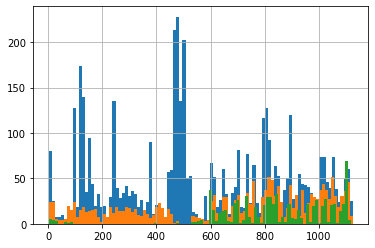

In [6]:
train[ train.fault_severity == 0  ].location.hist(bins=100)
train[ train.fault_severity == 1  ].location.hist(bins=100)
train[ train.fault_severity == 2  ].location.hist(bins=100);

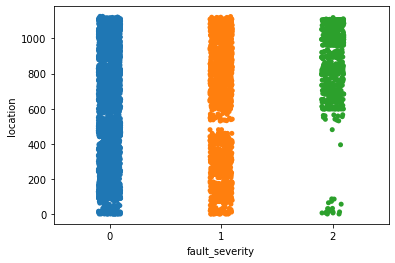

In [7]:
sns.stripplot(x="fault_severity", y="location", data=train, jitter=True);

Wygląda na to, że są lokalizacje, pomiędzy 100 a 600, gdzie w ogóle nie występuje stan **2** (krytyczny). Jest to trochę podejrzane, bo czemu akurat tak? Być może jest tam lepszy sprzęt... Tego nie wiemy.

## Event type
Zbadajmy teraz rodzaje zdarzeń.

In [8]:
print(event_type.shape)
print("unique ID: ", event_type.id.nunique())
print("unique event_type: ", event_type.event_type.nunique())
event_type.sample(5)

(31170, 2)
unique ID:  18552
unique event_type:  53


,id,event_type
9162,16172,event_type 11
6189,5275,event_type 35
3107,2811,event_type 15
27723,1994,event_type 44
15664,1301,event_type 35


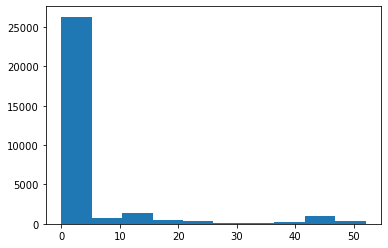

In [9]:
plt.hist( event_type.event_type.factorize()[0] );

In [10]:
event_type.event_type.value_counts(normalize=True).head(15)

event_type 11    0.253064
event_type 35    0.212223
event_type 34    0.190151
event_type 15    0.141001
event_type 20    0.046776
event_type 54    0.021944
event_type 13    0.018672
event_type 42    0.015335
event_type 44    0.014950
event_type 23    0.013763
event_type 14    0.010587
event_type 43    0.009817
event_type 22    0.007154
event_type 50    0.004941
event_type 10    0.004652
Name: event_type, dtype: float64

**event_type 11** jest najbardziej popularnym zdarzeniem (25%), następnie **event_type 35** - 21%, **event_type 34** - 19%, **event_type 15** - 14%. Pierwsze cztery zdarzenia stanowią ok. 80%.

## Resource type

In [11]:
print(resource_type.shape)
print("unique ID: ", resource_type.id.nunique())
print("unique resource_type: ", resource_type.resource_type.nunique())
resource_type.sample(5)

(21076, 2)
unique ID:  18552
unique resource_type:  10


,id,resource_type
5931,12069,resource_type 2
4094,10070,resource_type 2
19020,3545,resource_type 6
6377,1577,resource_type 2
10068,8564,resource_type 2


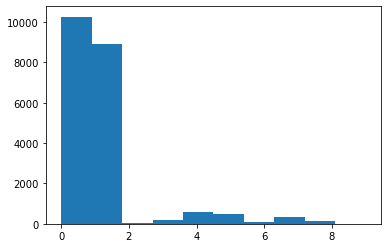

In [12]:
plt.hist( resource_type.resource_type.factorize()[0] );

In [13]:
resource_type.resource_type.value_counts(normalize=True)

resource_type 8     0.487189
resource_type 2     0.423135
resource_type 6     0.027614
resource_type 7     0.023629
resource_type 4     0.015658
resource_type 9     0.009015
resource_type 3     0.006880
resource_type 10    0.003464
resource_type 1     0.002752
resource_type 5     0.000664
Name: resource_type, dtype: float64

**resource_type 8** ma ok. 49%, **resource_type 2** - 42%, co pokrywa ponad 90%.

## Severity_type

In [14]:
print(severity_type.shape)
print("unique ID: ", severity_type.id.nunique())
print("unique severity_type: ", severity_type.severity_type.nunique())
severity_type.sample(5)

(18552, 2)
unique ID:  18552
unique severity_type:  5


,id,severity_type
5521,4523,severity_type 2
13939,553,severity_type 1
16247,9797,severity_type 1
12428,15674,severity_type 1
13120,14887,severity_type 1


In [15]:
severity_type.severity_type.value_counts(normalize=True)

severity_type 2    0.470947
severity_type 1    0.470461
severity_type 4    0.054657
severity_type 5    0.003504
severity_type 3    0.000431
Name: severity_type, dtype: float64

## Basic model
Metryką sukcesu jest [logloss](https://bit.ly/3aiypVO).

In [16]:
def cv_model(model, X, y, n_splits=3):

    scores = []
    skf = StratifiedKFold(n_splits=n_splits, random_state=2018, shuffle=True)

    for train_idx, test_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict_proba(X[test_idx])

        scores.append( log_loss(y[test_idx], y_pred) )
        
    return np.mean(scores), np.std(scores)

In [17]:
X = train[ ['location'] ].values
y = train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.8035725329559632, 0.03883194903503622)

Już zwykłe drzewa decyzyjne dają wynik: **0.838**. Spróbujemy wyciągnąć więcej.

## Merge `train` & `severity_type`
Zaczniemy od łączenia `severity_type` z `train`, dlatego że w tym przypadku są relacje: 1x1.

In [18]:
combined_train = pd.merge(severity_type, train, on='id')

combined_train

,id,severity_type,location,fault_severity
0,8011,severity_type 2,1,0
1,2588,severity_type 1,1,0
2,4848,severity_type 1,1,0
3,6914,severity_type 1,1,0
4,5337,severity_type 1,1,0
...,...,...,...,...
7376,6288,severity_type 1,999,1
7377,13296,severity_type 1,999,1
7378,8114,severity_type 2,999,0
7379,878,severity_type 2,999,0


Zwróć uwagę na cechę `location`. Czy widzisz, że to jest ułożone w sposób rosnący? Możemy założyć, że po połączeniu tablic, uzyskaliśmy wiersze posortowane w czasie.

Sprawdźmy to! Wybierzemy trzy najbardziej popularne (z największą ilością danych) lokalizacje.

In [19]:
combined_train.location.value_counts().head()

821     85
1107    78
734     75
1008    71
126     71
Name: location, dtype: int64

Dla lokalizacji **821** posiadamy 85 wierszy, dla **1107** - 78, **734** - 75.

In [20]:
tmp_exp = combined_train[ combined_train.location == 821 ].reset_index()
tmp_exp['id'] = tmp_exp.index
print(tmp_exp.shape)
tmp_exp.head()

(85, 5)


,index,id,severity_type,location,fault_severity
0,5860,0,severity_type 1,821,0
1,5861,1,severity_type 1,821,0
2,5862,2,severity_type 1,821,0
3,5863,3,severity_type 1,821,0
4,5864,4,severity_type 1,821,0


**id** zawiera kolejne liczby w sposób rosnący (zaczynając od 0). Czas na wizualizację.

In [21]:
def plot_by_location(location_id):
    tmp_exp = combined_train[ combined_train.location == location_id ].reset_index()
    tmp_exp['id'] = tmp_exp.index

    sns.set(rc={'figure.figsize':(15,5)})

    plt.plot( tmp_exp[ tmp_exp.fault_severity == 0 ].id, tmp_exp[ tmp_exp.fault_severity == 0 ].fault_severity, 'o' )
    plt.plot( tmp_exp[ tmp_exp.fault_severity == 1 ].id, tmp_exp[ tmp_exp.fault_severity == 1 ].fault_severity, 'o' )
    plt.plot( tmp_exp[ tmp_exp.fault_severity == 2 ].id, tmp_exp[ tmp_exp.fault_severity == 2 ].fault_severity, 'o' )
    plt.title("Location {0}".format(location_id), fontsize=20)
    plt.xlabel("Num", fontsize=16)
    plt.ylabel("Fault severity", fontsize=16)
    plt.show()

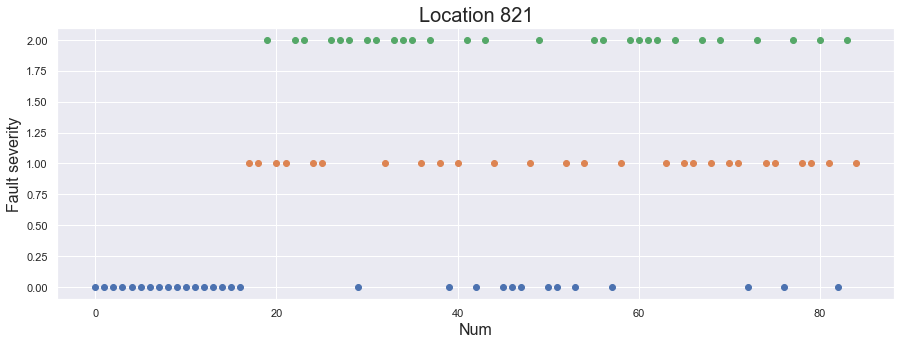

In [22]:
plot_by_location(821)

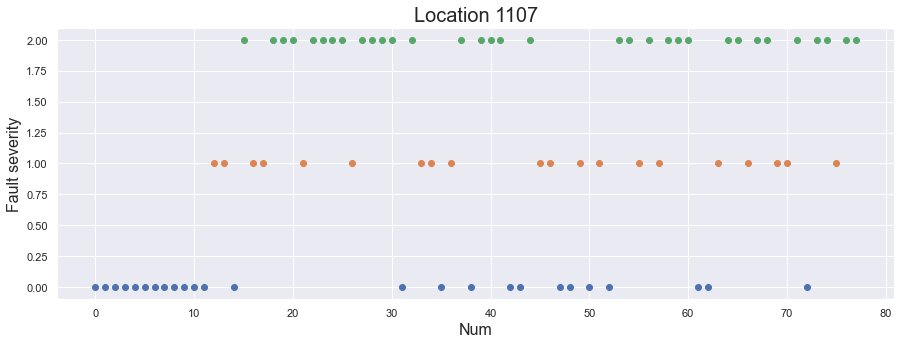

In [23]:
plot_by_location(1107)

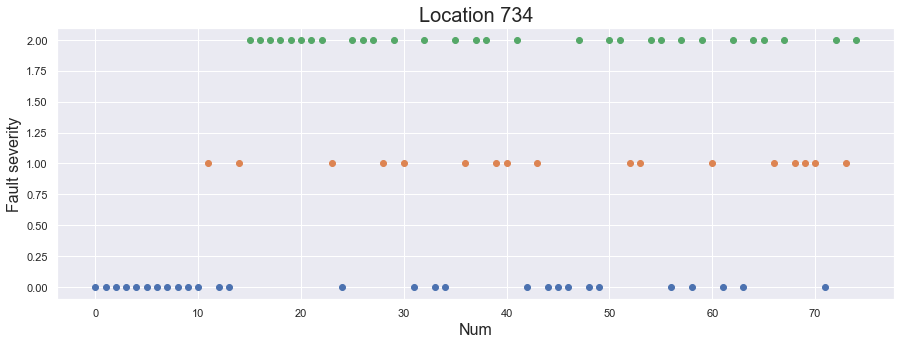

In [24]:
plot_by_location(734)

Na osi X jest stworzona nowa (eksperymentalna) cecha, która prawdopodobnie jest czasem. Jak widać, to założenie może mieć sens. Najpierw wszystko jest dobrze (stan 0 - niebieskie kropki), następnie są częściowe trudności (stan 1, zielone kropki) i następnie krytycznie (stan 2 - czerwone kropki).

Teraz wytrenujmy model i sprawdźmy, czy ta hipoteza może być pomocna.

In [25]:
combined_train['time'] = combined_train.groupby('location')['severity_type'].transform(lambda x: np.arange(x.shape[0])+1)
combined_train['reverse_time'] = combined_train.groupby('location')['severity_type'].transform(lambda x: np.arange(x.shape[0])[::-1]+1)

combined_train.head()

,id,severity_type,location,fault_severity,time,reverse_time
0,8011,severity_type 2,1,0,1,24
1,2588,severity_type 1,1,0,2,23
2,4848,severity_type 1,1,0,3,22
3,6914,severity_type 1,1,0,4,21
4,5337,severity_type 1,1,0,5,20


## DT + `time`: ~0.78

In [26]:
X = combined_train[ ['location', 'time'] ].values
y = combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.8268849840870119, 0.028977305219066718)

## DT + `reverse_time`: ~0.81

In [27]:
X = combined_train[ ['location', 'reverse_time'] ].values
y = combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.795292325423025, 0.05361078304768331)

## DT + `time` + `reverse_time`: ~0.74

In [28]:
X = combined_train[ ['location', 'reverse_time', 'time'] ].values
y = combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.7563630985981975, 0.03504595647558953)

*Basic model* miał **0.838**, widać że cechy: `time` i `reverse_time` poprawiły model do **0.748**.

## Location count
Pogrupujmy dane po lokalizacji, innymi słowy - ile mamy wierszy dla podanej lokalizacji.

In [29]:
combined_train[ ['location', 'time'] ].groupby('location').agg(len).head(5)

,time
location,
1,24
2,7
3,2
4,2
5,1


In [30]:
location_count = combined_train[ ['location', 'time'] ].groupby('location').agg(len).to_dict()['time']
combined_train['location_count'] = combined_train['location'].map(lambda x: location_count[x])

combined_train.head()

,id,severity_type,location,fault_severity,time,reverse_time,location_count
0,8011,severity_type 2,1,0,1,24,24
1,2588,severity_type 1,1,0,2,23,24
2,4848,severity_type 1,1,0,3,22,24
3,6914,severity_type 1,1,0,4,21,24
4,5337,severity_type 1,1,0,5,20,24


In [31]:
X = combined_train[ ['location', 'reverse_time', 'time', 'location_count'] ].values
y = combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.7540138486008233, 0.02825339391234813)

Kolejna (drobna) poprawa: **0.742** vs **0.748**.

## Agregacja

Spróbujmy teraz poagregować dane. Zaczniemy od **event_type** (może być inna tabela, to nie ma większego znaczenia).

In [32]:
def map_to_int(x):
    return int(x.split(' ')[1])

event_type['event_type'] = event_type.event_type.map(map_to_int)

In [33]:
def group_et_by_location(df):
    agg_et = pd.merge(df, event_type, on='id')
    
    agg_funcs = [np.median, np.mean, np.max, np.min, len, np.sum]
    
    for agg_func in agg_funcs:
        dict_et_by_location = agg_et.groupby('location')['event_type'].agg(agg_func).to_dict()
        df['{0}_et_by_location'.format(agg_func.__name__)] = df.location.map(lambda x: dict_et_by_location[x])
    
    return df

combined_train = group_et_by_location(combined_train)
combined_train.head()

,id,severity_type,location,fault_severity,time,reverse_time,location_count,median_et_by_location,mean_et_by_location,amax_et_by_location,amin_et_by_location,len_et_by_location,sum_et_by_location
0,8011,severity_type 2,1,0,1,24,24,15.0,13.255814,20,7,43,570
1,2588,severity_type 1,1,0,2,23,24,15.0,13.255814,20,7,43,570
2,4848,severity_type 1,1,0,3,22,24,15.0,13.255814,20,7,43,570
3,6914,severity_type 1,1,0,4,21,24,15.0,13.255814,20,7,43,570
4,5337,severity_type 1,1,0,5,20,24,15.0,13.255814,20,7,43,570


In [34]:
feats_by_location = [feat for feat in combined_train.columns if '_by_location' in feat]
feats_by_location

['median_et_by_location',
 'mean_et_by_location',
 'amax_et_by_location',
 'amin_et_by_location',
 'len_et_by_location',
 'sum_et_by_location']

In [35]:
X = combined_train[ ['location', 'reverse_time', 'time', 'location_count'] + feats_by_location ].values
y = combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.7895037310332511, 0.04634393268157878)

Niestety jest gorzej, ale szukamy dalej: **0.783** vs **0.742**

In [36]:
event_type.event_type.value_counts(normalize=True).head(15)

11    0.253064
35    0.212223
34    0.190151
15    0.141001
20    0.046776
54    0.021944
13    0.018672
42    0.015335
44    0.014950
23    0.013763
14    0.010587
43    0.009817
22    0.007154
50    0.004941
10    0.004652
Name: event_type, dtype: float64

Pierwsze cztery `event type` stanowią ok. 80% wszystkich. Dlatego warto rozważyć podzielenie danych na grupy/koszyki (ang. *buckets*). Niech będą trzy grupy: **high**, **medium** i **low**.

In [37]:
def map_event_type(x):
    if x in [11, 35, 34]: return 'high'
    if x in [15, 20,54,13,42,44,23, 14]: return 'medium'
    return 'low'


tmp_event_type = pd.merge(event_type, train, on='id')
tmp_event_type['event_type_map'] = tmp_event_type['event_type'].map(map_event_type)

In [38]:
dict_crosstab = pd.crosstab(tmp_event_type.event_type_map, tmp_event_type.fault_severity).apply(lambda r: r/r.sum(), axis=1).to_dict()
dict_crosstab

{0: {'high': 0.7339696524718551,
  'low': 0.49937421777221525,
  'medium': 0.47698026880183014},
 1: {'high': 0.21598139990210474,
  'low': 0.3541927409261577,
  'medium': 0.31226765799256506},
 2: {'high': 0.05004894762604014,
  'low': 0.14643304130162704,
  'medium': 0.2107520732056048}}

In [39]:
for fault_severity in [0, 1, 2]:
    tmp_event_type['event_type_map_{0}'.format(fault_severity)] = tmp_event_type['event_type_map'].map(lambda x: dict_crosstab[fault_severity][x] )

tmp_event_type[ ['event_type_map_0', 'event_type_map_1', 'event_type_map_2'] ].head()

,event_type_map_0,event_type_map_1,event_type_map_2
0,0.47698,0.312268,0.210752
1,0.47698,0.312268,0.210752
2,0.73397,0.215981,0.050049
3,0.73397,0.215981,0.050049
4,0.47698,0.312268,0.210752


In [40]:
prob_event_type = tmp_event_type.groupby('id').agg(np.mean)[['event_type_map_0', 'event_type_map_1', 'event_type_map_2']]
prob_event_type.reset_index(inplace=True)
prob_event_type.head()

,id,event_type_map_0,event_type_map_1,event_type_map_2
0,1,0.605475,0.264125,0.130401
1,5,0.733970,0.215981,0.050049
2,6,0.733970,0.215981,0.050049
3,8,0.733970,0.215981,0.050049
4,13,0.733970,0.215981,0.050049


### Jak to należy interpretować?
Dla przykładu sprawdzimy `ID=1`.

In [41]:
tmp_event_type[ tmp_event_type.id == 1 ]

,id,event_type,location,fault_severity,event_type_map,event_type_map_0,event_type_map_1,event_type_map_2
7359,1,11,601,1,high,0.73397,0.215981,0.050049
7360,1,13,601,1,medium,0.47698,0.312268,0.210752


Jak widzimy mamy dwa wiersze, to oznacza, że wystąpiły dwa wydarzenia: `event_type=11` oraz `event_type=13`. 

Nasza zmienna docelowa ma trzy stany: 0, 1 i 2. Pytanie: jeśli wystąpi zdarzenie 11 (`event_type=11`), jakie jest prawdopodobieństwo, że zmienna docelowa (`fault_severity`) będzie miała stan 0? Sprawdź kolumnę `event_type_map_0` i tam jest wartość **0.73397** czyli prawdopodobieństwo jest ok. **74%**. 

Natomiast mamy jeszcze jedno zdarzenie (`event_type=13`) i dla tego zdarzenia prawdopodobieństwo, że będzie stan 0 jest znacznie mniejsze: ok. **48%** (**0.47698**). Teraz łączymy dwie liczby (znajdujemy średnią). W wyniku tego dowiadujemy się, że dla `ID=1` prawdopodobieństwo stanu 0 to ok. **61%** (**0.605475**).

Podobne jest wyliczane dla każdego unikalnego ID. Sprawdźmy, czy to na pomogło usprawnić jakość modelu.

In [42]:
prob_event_type.head()

,id,event_type_map_0,event_type_map_1,event_type_map_2
0,1,0.605475,0.264125,0.130401
1,5,0.733970,0.215981,0.050049
2,6,0.733970,0.215981,0.050049
3,8,0.733970,0.215981,0.050049
4,13,0.733970,0.215981,0.050049


In [43]:
tmp_combined_train = pd.merge(combined_train, prob_event_type, on='id')
tmp_combined_train.head()

,id,severity_type,location,fault_severity,time,reverse_time,location_count,median_et_by_location,mean_et_by_location,amax_et_by_location,amin_et_by_location,len_et_by_location,sum_et_by_location,event_type_map_0,event_type_map_1,event_type_map_2
0,8011,severity_type 2,1,0,1,24,24,15.0,13.255814,20,7,43,570,0.476980,0.312268,0.210752
1,2588,severity_type 1,1,0,2,23,24,15.0,13.255814,20,7,43,570,0.605475,0.264125,0.130401
2,4848,severity_type 1,1,0,3,22,24,15.0,13.255814,20,7,43,570,0.605475,0.264125,0.130401
3,6914,severity_type 1,1,0,4,21,24,15.0,13.255814,20,7,43,570,0.605475,0.264125,0.130401
4,5337,severity_type 1,1,0,5,20,24,15.0,13.255814,20,7,43,570,0.605475,0.264125,0.130401


In [44]:
prob_event_type_feats = [ 'event_type_map_0', 'event_type_map_1', 'event_type_map_2' ]

X = tmp_combined_train[ ['location', 'reverse_time', 'time', 'location_count'] + feats_by_location + prob_event_type_feats ].values
y = tmp_combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.772384670029817, 0.043947704291351246)

W tym konkretnym przypadku wynik trochę się polepszył, ale warto sprawdzić na innych, bardziej zaawansowanych modelach.

## Random Forest i XGBoost

In [45]:
prob_event_type_feats = [ 'event_type_map_0', 'event_type_map_1', 'event_type_map_2' ]

X = tmp_combined_train[ ['location', 'reverse_time', 'time', 'location_count'] + feats_by_location + prob_event_type_feats ].values
y = tmp_combined_train['fault_severity'].values

cv_model(RandomForestClassifier(max_depth=10, n_estimators=20, random_state=2019), X, y)

(0.6470660690566628, 0.004592577951177747)

In [46]:
prob_event_type_feats = [ 'event_type_map_0', 'event_type_map_1', 'event_type_map_2' ]

X = tmp_combined_train[ ['location', 'reverse_time', 'time', 'location_count'] + feats_by_location + prob_event_type_feats ].values
y = tmp_combined_train['fault_severity'].values

xgb_params = {
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'max_depth': 5,
    'n_estimators': 50,
    'learning_rate': 0.17,
    'random_state': 2019,
}
cv_model(xgb.XGBClassifier(**xgb_params), X, y)

/Users/mmastalerczyk/opt/anaconda3/envs/umap2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mmastalerczyk/opt/anaconda3/envs/umap2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mmastalerczyk/opt/anaco

(0.6279729286587679, 0.0045205530526793705)

Już mamy znowu lepsze wyniki :).

Można jeszcze dołożyć kilka nowych cech (chociażby agregując podobnie jak to było z `event_type`).

Teraz chcę Ci pokazać jeszcze jedną ciekawostkę - kalibracja: [Probability Calibration curves](https://bit.ly/3agGYjQ) + [multi class](https://bit.ly/3x1W1Yl)

## Przydatne linki:
1. [Webinar: ciężko było mi wtedy mówić, ale może będzie przydatne](https://bit.ly/3dqVlnD)
2. [Telstra Network Disruptions Competition Writeup](https://bit.ly/3e8o8MV)
3. [Vancouver Kaggle Meetup 2016-04-07](https://bit.ly/32mVG4t)